<a href="https://colab.research.google.com/github/vsemwal/human-walking-activities/blob/master/har_with_cnn_initial_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install coremltools


     |████████████████████████████████| 3.4MB 2.8MB/s 


In [2]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D,Conv1D, MaxPooling1D
from keras.utils import np_utils

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)
# Same labels will be reused throughout the program
LABELS = ['downstair',
          'úpstair',
          'jogging',
          'situp',
          'walkonheel',
          'walkontoe',
          'normalwalk']
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

keras version  2.3.1


In [0]:
# !wget  http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz 
# !ls

In [0]:
# !tar -xvf WISDM_ar_latest.tar.gz

In [0]:
def read_data(file_path):

    df = pd.read_csv (file_path,index_col=False)
 
    # ... and then this column must be transformed to float explicitly
    df['ax'] = df['ax'].apply(convert_to_float)
    df['ay'] = df['ay'].apply(convert_to_float)
    df['az'] = df['az'].apply(convert_to_float)
    df['wx'] = df['wx'].apply(convert_to_float)
    df['wy'] = df['wy'].apply(convert_to_float)
    df['wz'] = df['wz'].apply(convert_to_float)
    df['angleX'] = df['angleX'].apply(convert_to_float)
    df['angleY'] = df['angleY'].apply(convert_to_float)
    df['angleZ'] = df['angleZ'].apply(convert_to_float)
    df['temp'] = df['temp'].apply(convert_to_float)
    
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    # print(df)
    df.drop(['wx',
                    'wy',
                    'wz',
                    'angleX',
                    'angleY',
                    'angleZ',
                    'temp'],axis=1,inplace=True) 
    df.dropna(axis=0, how='any', inplace=True)
    # print(df)
    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

# Load data set containing all the data from csv
df = read_data(r'allf.csv')

In [7]:
# Describe the data
show_basic_dataframe_info(df)
df.tail(10)


Number of columns in the dataframe: 6
Number of rows in the dataframe: 72154



,uid,activity,time,ax,ay,az
72147,10,jogging,2202990,0.2,-0.4,1.7
72148,10,jogging,2202990,0.1,-0.2,1.7
72149,10,jogging,2202991,0.0,-0.1,1.7
72150,10,jogging,2203275,-0.0,0.1,1.7
72151,10,jogging,2203275,-0.1,0.2,1.7
72152,10,jogging,2203275,-0.1,0.3,1.8
72153,10,jogging,2203275,-0.0,0.3,1.9
72154,10,jogging,2203275,-0.0,0.4,2.0
72155,10,jogging,2203275,-0.0,0.4,2.2
72156,10,jogging,2203275,-0.0,0.4,2.5


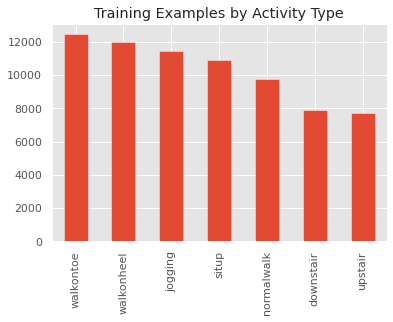

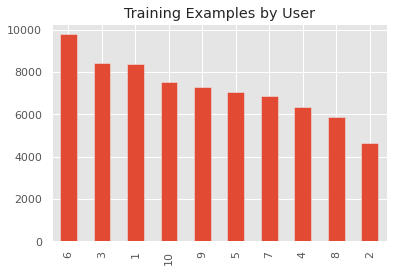

In [8]:
# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()
# Better understand how the recordings are spread across the different
# users who participated in the study
df['uid'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

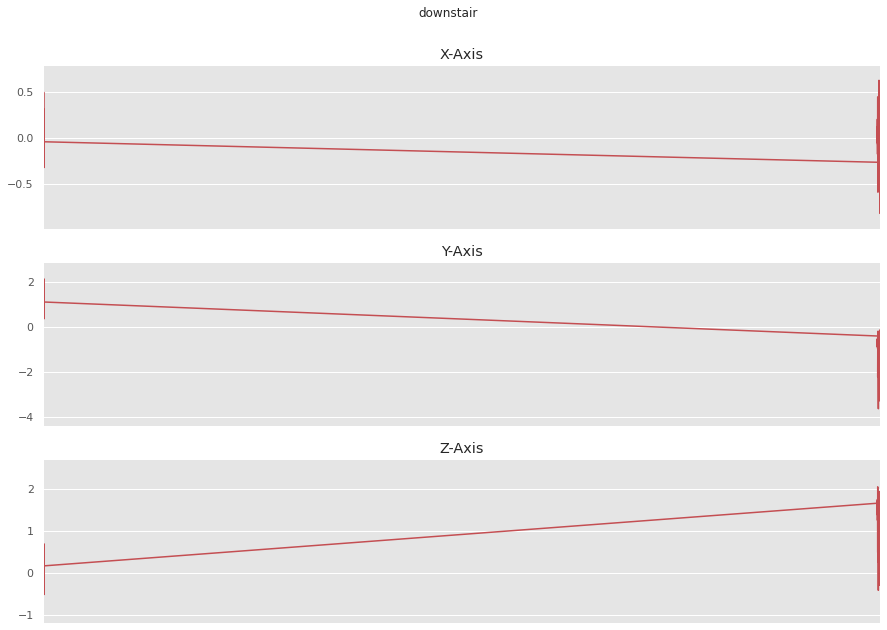

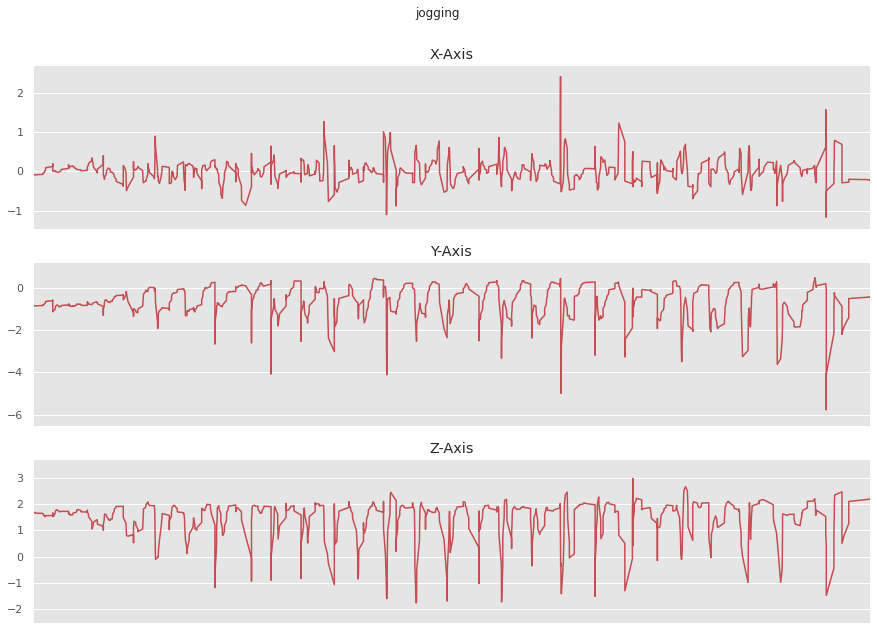

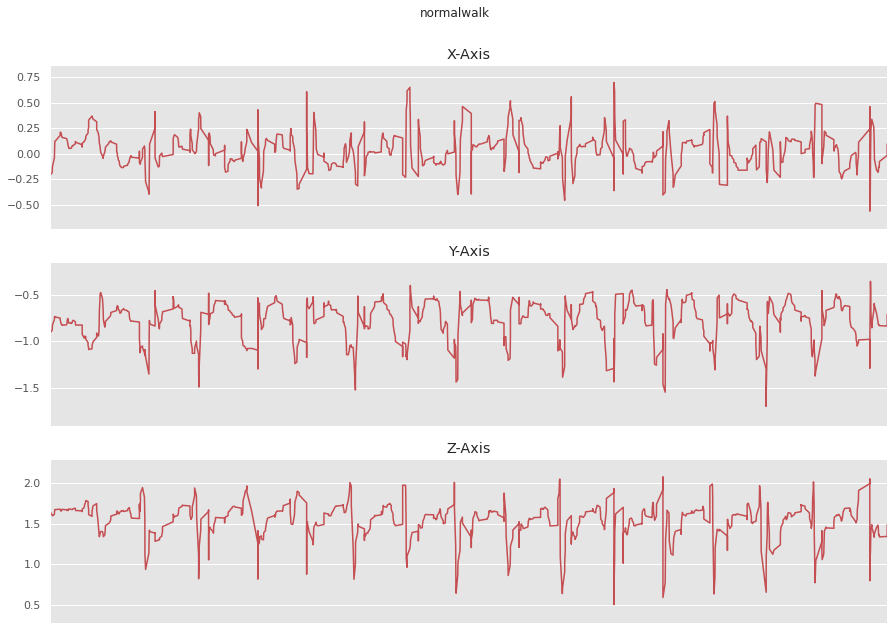

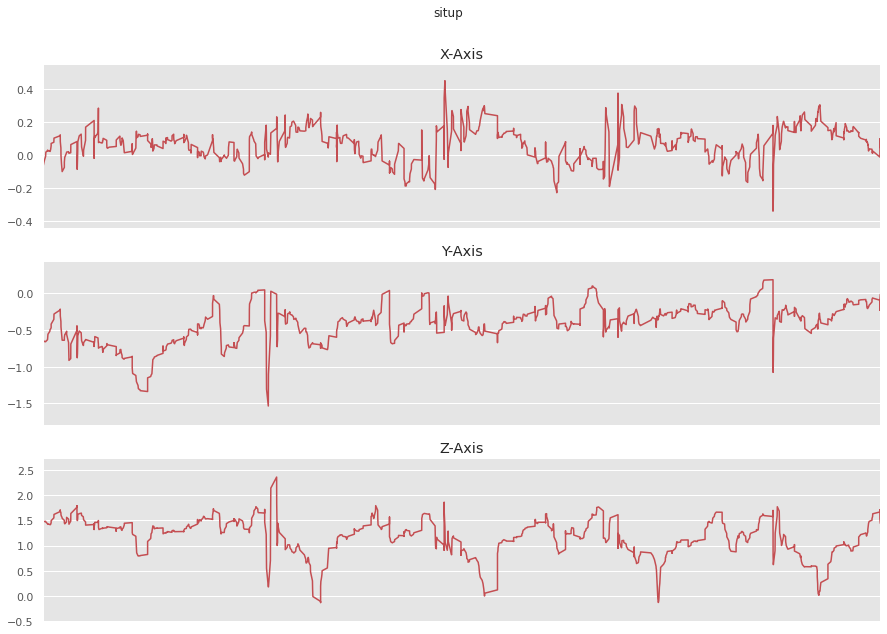

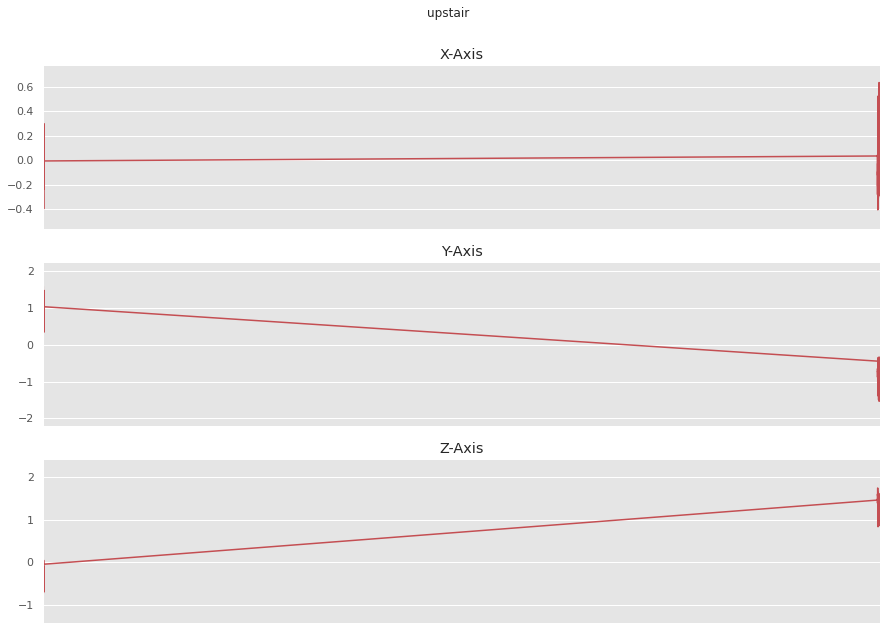

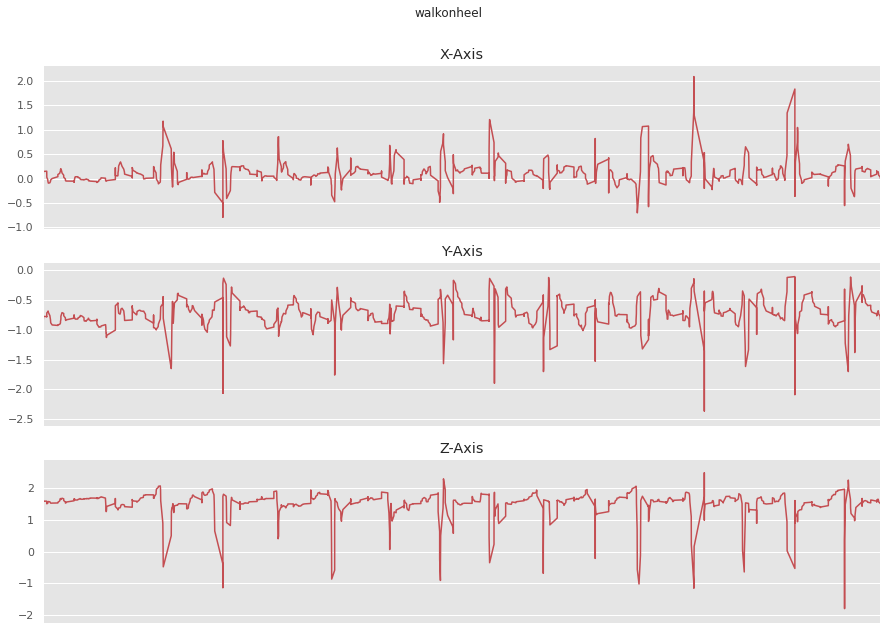

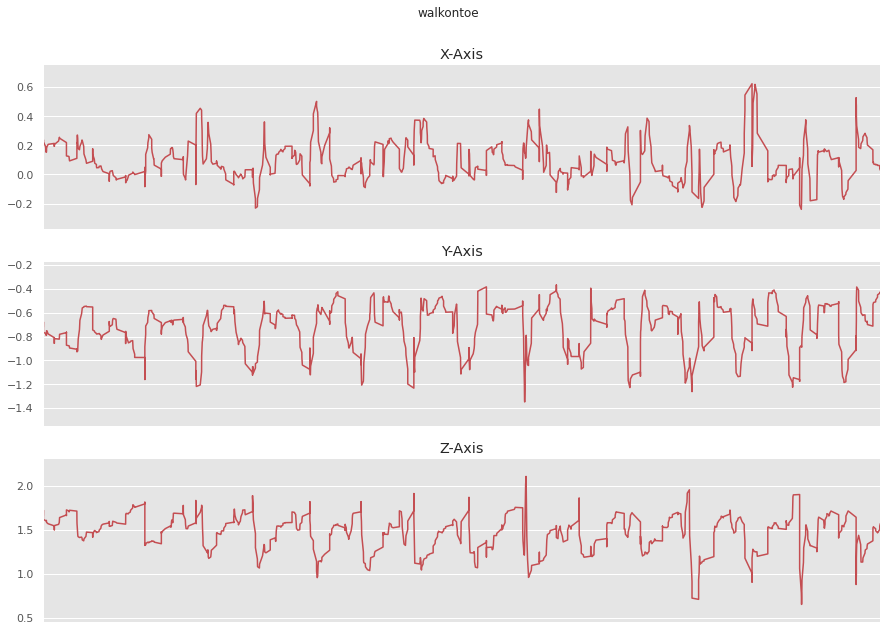

In [10]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['time'], data['ax'], 'X-Axis')
    plot_axis(ax1, data['time'], data['ay'], 'Y-Axis')
    plot_axis(ax2, data['time'], data['az'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:1000]
    plot_activity(activity, subset)

In [0]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [0]:
# Differentiate between test set and training set
# df_test = df[df['uid'] > 7]
# df_train = df[df['uid'] <= 7]
# print(df_test["ax"])

In [0]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df['ax'] = df['ax'] / df['ax'].max()
df['ay'] = df['ay'] / df['ay'].max()
df['az'] = df['az'] / df['az'].max()
# print(df_test['ax'])
# df_test['ax'] = df_test['ax'] / df_test['ax'].max()
# df_test['ay'] = df_test['ay'] / df_test['ay'].max()
# df_test['az'] = df_test['az'] / df_test['az'].max()
# Round numbers
# print(df_test['ax'])
# df_train = df_train.round({'ax': 4, 'ay': 4, 'az': 4})

In [0]:
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['ax'].values[i: i + time_steps]
        ys = df['ay'].values[i: i + time_steps]
        zs = df['az'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x, y = create_segments_and_labels(df,TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

# print(x_train)
# print(x_test)
# print(y_test)
# print(y_train)

In [14]:
# print(x_test)
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)
print('x_test shape: ', x_test.shape)
print(x_test.shape[0], 'testing samples')
print('y_test shape: ', y_test.shape)

x_train shape:  (1441, 80, 3)
1441 training samples
y_train shape:  (1441,)
x_test shape:  (361, 80, 3)
361 testing samples
y_test shape:  (361,)


In [15]:
# Set input & output dimensions
n_timesteps=  x_train.shape[1]
n_features= x_train.shape[2]

num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['downstair', 'jogging', 'normalwalk', 'situp', 'upstair', 'walkonheel', 'walkontoe']


In [0]:
# input_shape = (num_time_periods*num_sensors)
# x_train = x_train.reshape(x_train.shape[0], input_shape)
# print('x_train shape:', x_train.shape)
# print('input_shape:', input_shape)
# x_test = x_test.reshape(x_test.shape[0], input_shape)
# print('x_test shape:', x_test.shape)
# print('input_shape:', input_shape)

In [0]:
# x_train = x_train.astype('float32')
# y_train = y_train.astype('float32')
# x_test = x_test.astype('float32')
# y_test = y_test.astype('float32')

In [16]:
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)
y_test_hot = np_utils.to_categorical(y_test, num_classes)
print('New y_test shape: ', y_test_hot.shape)
n_outputs=y_train_hot.shape[1]

New y_train shape:  (1441, 7)
New y_test shape:  (361, 7)


In [0]:
# model_m = Sequential()
# # Remark: since coreml cannot accept vector shapes of complex shape like
# # [80,3] this workaround is used in order to reshape the vector internally
# # prior feeding it into the network
# model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
# model_m.add(Dense(100, activation='relu'))
# model_m.add(Dense(100, activation='relu'))
# model_m.add(Dense(100, activation='relu'))
# model_m.add(Flatten())
# model_m.add(Dense(num_classes, activation='softmax'))

# print(model_m.summary())

In [17]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 78, 64)            640       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 76, 64)            12352     
_________________________________________________________________
dropout_1 (Dropout)          (None, 76, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 38, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               243300    
_________________________________________________________________
dense_2 (Dense)              (None, 7)                

In [18]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 10
EPOCHS = 30

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 1152 samples, validate on 289 samples
Epoch 1/30
1152/1152 [==============================] - 1s 1ms/step - loss: 1.7243 - accuracy: 0.2908 - val_loss: 1.5202 - val_accuracy: 0.3979
Epoch 2/30
 210/1152 [====>.........................] - ETA: 0s - loss: 1.3020 - accuracy: 0.5143

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1152/1152 [==============================] - 1s 858us/step - loss: 1.3299 - accuracy: 0.4688 - val_loss: 1.4066 - val_accuracy: 0.4533
Epoch 3/30
1152/1152 [==============================] - 1s 836us/step - loss: 1.1679 - accuracy: 0.5425 - val_loss: 1.3487 - val_accuracy: 0.4844
Epoch 4/30
1152/1152 [==============================] - 1s 889us/step - loss: 1.0759 - accuracy: 0.5790 - val_loss: 1.2561 - val_accuracy: 0.5260
Epoch 5/30
1152/1152 [==============================] - 1s 822us/step - loss: 0.9779 - accuracy: 0.6250 - val_loss: 1.1683 - val_accuracy: 0.5709
Epoch 6/30
1152/1152 [==============================] - 1s 829us/step - loss: 0.8507 - accuracy: 0.7101 - val_loss: 1.0976 - val_accuracy: 0.6055
Epoch 7/30
1152/1152 [==============================] - 1s 872us/step - loss: 0.7990 - accuracy: 0.7222 - val_loss: 1.1496 - val_accuracy: 0.5986
Epoch 8/30
1152/1152 [==============================] - 1s 868us/step - loss: 0.7118 - accuracy: 0.7361 - val_loss: 1.0755 - val_accura

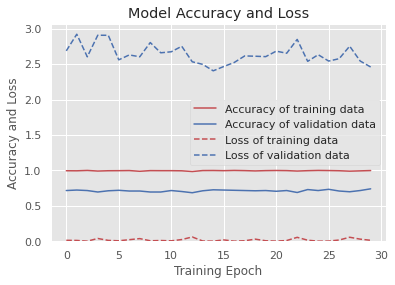

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       163
           1       0.98      0.97      0.97       230
           2       0.94      0.95      0.94       198
           3       0.97      0.94      0.95       216
           4       0.92      0.93      0.93       145
           5       0.96      0.96      0.96       241
           6       0.95      0.94      0.95       248

    accuracy                           0.95      1441
   macro avg       0.94      0.95      0.95      1441
weighted avg       0.95      0.95      0.95      1441



In [0]:
# history_dict = history.history
# history_dict.keys()
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

test data:


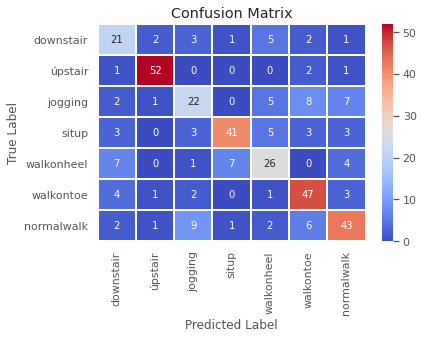

              precision    recall  f1-score   support

           0       0.53      0.60      0.56        35
           1       0.91      0.93      0.92        56
           2       0.55      0.49      0.52        45
           3       0.82      0.71      0.76        58
           4       0.59      0.58      0.58        45
           5       0.69      0.81      0.75        58
           6       0.69      0.67      0.68        64

    accuracy                           0.70       361
   macro avg       0.68      0.68      0.68       361
weighted avg       0.70      0.70      0.70       361

test data:


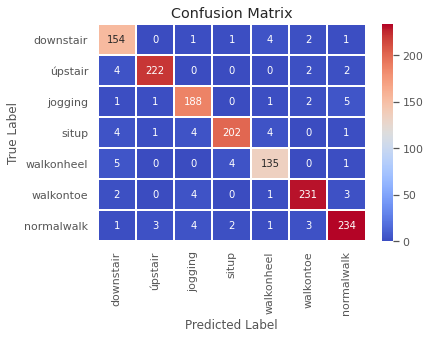

In [0]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
# print(x_test)
y_pred_test = model.predict(x_test)
# print(y_pred_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
# print(y_test_hot.shape)
# print(y_pred_test.shape)
max_y_test = np.argmax(y_test_hot, axis=1)
print("test data:")
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

print("test data:")
_pred_test = model.predict(x_train)
# print(y_pred_test)
# Take the class with the highest probability from the test predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
# print(y_test_hot.shape)
# print(y_pred_test.shape)
max_y_train = np.argmax(y_train_hot, axis=1)

show_confusion_matrix(max_y_train, max_y_pred_train)



In [0]:
coreml_model = coremltools.converters.keras.convert(model_m,
                                                    input_names=['acceleration'],
                                                    output_names=['output'],
                                                    class_labels=LABELS)

print(coreml_model)
coreml_model.author = 'Nils Ackermann'
coreml_model.license = 'N/A'
coreml_model.short_description = 'Activity based recognition based on WISDM dataset'
coreml_model.output_description['output'] = 'Probability of each activity'
coreml_model.output_description['classLabel'] = 'Labels of activity'

coreml_model.save('HARClassifier.mlmodel')

NameError: ignored

In [0]:
print('\nPrediction from Keras:')
test_record = x_test[1].reshape(1,input_shape)
keras_prediction = np.argmax(model_m.predict(test_record), axis=1)
print(le.inverse_transform(keras_prediction)[0])
print('\nPrediction from Coreml:')
coreml_prediction = coreml_model.predict({'acceleration': test_record.reshape(input_shape)})
print(coreml_prediction["classLabel"])